In [1]:
import os
import requests
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
tf.__version__

'2.0.0'

#### INTRUSION DETECTOR LEARNING
Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders.  The intrusion detector learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

The 1998 DARPA Intrusion Detection Evaluation Program was prepared and managed by MIT Lincoln Labs. The objective was to survey and evaluate research in intrusion detection.  A standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment, was provided.  The 1999 KDD intrusion detection contest uses a version of this dataset.

Lincoln Labs set up an environment to acquire nine weeks of raw TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN.  They operated the LAN as if it were a true Air Force environment, but peppered it with multiple attacks.

The raw training data was about four gigabytes of compressed binary TCP dump data from seven weeks of network traffic.  This was processed into about five million connection records.  Similarly, the two weeks of test data yielded around two million connection records.

A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol.  Each connection is labeled as either normal, or as an attack, with exactly one specific attack type.  Each connection record consists of about 100 bytes.

Attacks fall into four main categories:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.

It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data.  This makes the task more realistic.  Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants.  The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.
 
 
#### DERIVED FEATURES
Stolfo et al. defined higher-level features that help in distinguishing normal connections from attacks.  There are several categories of derived features.

The ``same host'' features examine only the connections in the past two seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc.

The similar ``same service'' features examine only the connections in the past two seconds that have the same service as the current connection.

"Same host" and "same service" features are together called  time-based traffic features of the connection records.

Some probing attacks scan the hosts (or ports) using a much larger time interval than two seconds, for example once per minute.  Therefore, connection records were also sorted by destination host, and features were constructed using a window of 100 connections to the same host instead of a time window.  This yields a set of so-called host-based traffic features.

Unlike most of the DOS and probing attacks, there appear to be no sequential patterns that are frequent in records of R2L and U2R attacks. This is because the DOS and probing attacks involve many connections to some host(s) in a very short period of time, but the R2L and U2R attacks are embedded in the data portions
of packets, and normally involve only a single connection.

Useful algorithms for mining the unstructured data portions of packets automatically are an open research question.  Stolfo et al. used domain knowledge to add features that look for suspicious behavior in the data portions, such as the number of failed login attempts.

In [2]:
attack_types, *features = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names').text.split('\n')[:-1]
attack_types = attack_types.split(',')
attack_types[-1] = attack_types[-1][:-1]
features_types_dict = {f.split(':')[0]: f.split(':')[1][1:-1] for f in features}
features = list(features_types_dict.keys())
features_types_dict['dst_host_srv_rerror_rate'] = 'continuous'
features_types_dict

{'duration': 'continuous',
 'protocol_type': 'symbolic',
 'service': 'symbolic',
 'flag': 'symbolic',
 'src_bytes': 'continuous',
 'dst_bytes': 'continuous',
 'land': 'symbolic',
 'wrong_fragment': 'continuous',
 'urgent': 'continuous',
 'hot': 'continuous',
 'num_failed_logins': 'continuous',
 'logged_in': 'symbolic',
 'num_compromised': 'continuous',
 'root_shell': 'continuous',
 'su_attempted': 'continuous',
 'num_root': 'continuous',
 'num_file_creations': 'continuous',
 'num_shells': 'continuous',
 'num_access_files': 'continuous',
 'num_outbound_cmds': 'continuous',
 'is_host_login': 'symbolic',
 'is_guest_login': 'symbolic',
 'count': 'continuous',
 'srv_count': 'continuous',
 'serror_rate': 'continuous',
 'srv_serror_rate': 'continuous',
 'rerror_rate': 'continuous',
 'srv_rerror_rate': 'continuous',
 'same_srv_rate': 'continuous',
 'diff_srv_rate': 'continuous',
 'srv_diff_host_rate': 'continuous',
 'dst_host_count': 'continuous',
 'dst_host_srv_count': 'continuous',
 'dst_hos

In [3]:
buf = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types').text
buf = buf.split('\n')[:-2]
target_classes = {
    'normal': 0,
    'u2r': 1,
    'r2l': 2,
    'probe': 3,
    'dos': 4
}
attack_types_dict = {line.split()[0]: line.split()[1] for line in buf}
attack_types_dict['normal'] = 'normal'
attack_types_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'normal': 'normal'}

In [4]:
_URL = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz'

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="kddcup.data.gz")

base_dir = os.path.join(os.path.dirname(zip_file), 'kddcup.data')
#df = pd.read_csv(url, header=None)

In [5]:
import gzip
import shutil

with gzip.open(zip_file, 'rb') as f_in:
    with open(base_dir, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin


class DFSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes_names]#.values

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

num_attrs = [0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32]
cat_attrs = [1, 2, 3, 41]

num_features_pipeline = Pipeline([
    ('DataFrame2Numpy', DFSelector(attributes_names=num_attrs)),
    ('Normalizer', MinMaxScaler())
])

cat_features_pipeline = Pipeline([
    ('DataFrame2Numpy', DFSelector(attributes_names=cat_attrs)),
    ('CategoricalEncoder', LabelBinarizer())
])

In [8]:
def data_preprocessing(data):
    data[num_attrs] = num_features_pipeline.fit_transform(data[num_attrs])
    data[cat_attrs] = cat_features_pipeline.fit_transform(data[cat_attrs])
    return data

In [9]:
BATCH_SIZE = 1000

lines_count = !wc -l {base_dir}
lines_count = int(lines_count[0].split()[0])
lines_count

4898431

In [10]:
#data_lines = tf.data.TextLineDataset(base_dir)
#data_batches = data_lines.batch(128)

#a = 1
#for i in data_batches:a = np.frombuffer(i)

In [11]:
#str(a[0])[2:-2].split()
#np.frombuffer(a)
#a

In [35]:
df = pd.read_csv(base_dir, header=None)
df[41] = [i[:-1] for i in df[41].values]
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


In [13]:
for i in (1, 2, 3, 41):
    print(df[i].value_counts(), end='\n\n')

icmp    2833545
tcp     1870598
udp      194288
Name: 1, dtype: int64

ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
aol                2
http_8001          2
harvest            2
http_2784          1
Name: 2, Length: 70, dtype: int64

SF        3744328
S0         869829
REJ        268874
RSTR         8094
RSTO         5344
SH           1040
S1            532
S2            161
RSTOS0        122
OTH            57
S3             50
Name: 3, dtype: int64

smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit   

In [14]:
for i in (1, 2, 3):
    classes_list = list(dict(df[i].value_counts()).keys())
    classes = {c: i for i, c in enumerate(classes_list)}
    df[i] = df[i].apply(lambda x: classes[x])
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
duration,0,1,2,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
protocol_type,0,1,2,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
service,0,1,2,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
flag,0,1,2,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
src_bytes,0,1,2,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,1,2,0,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,1,2,0,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,1,2,0,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,1,2,0,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


255    3363886
1       117468
2        70459
3        58016
4        55638
        ...   
199        610
202        607
207        547
206        523
0           33
Name: 32, Length: 256, dtype: int64

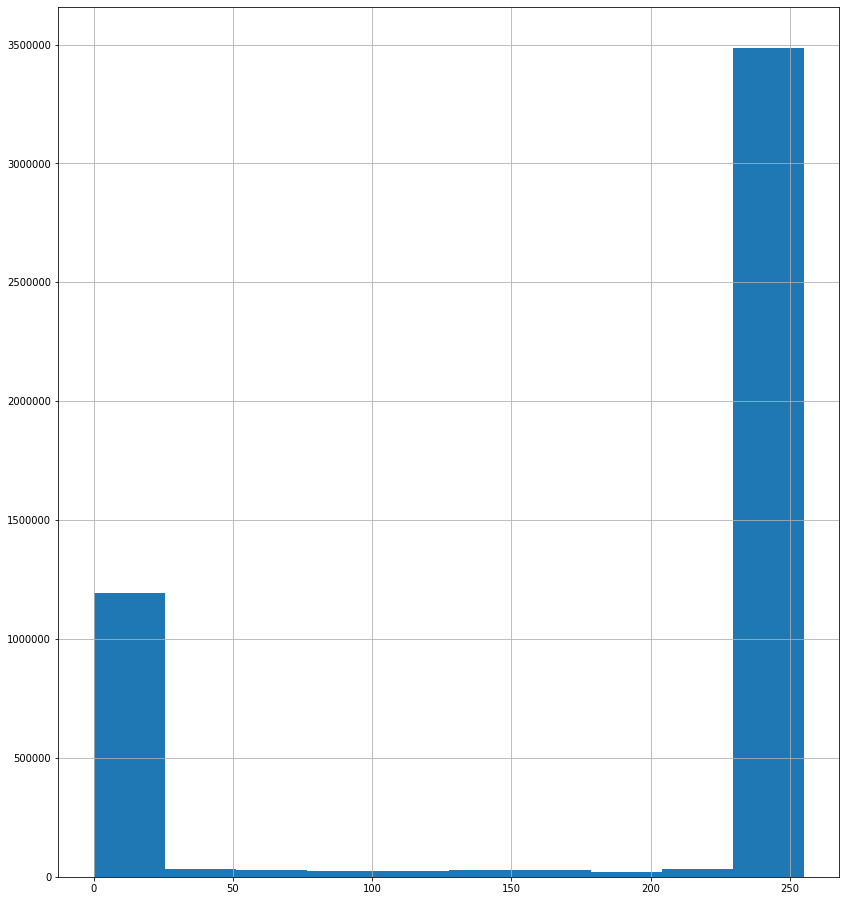

In [15]:
df[32].hist(figsize=(14, 16))
df[32].value_counts()
#plt.show()

In [16]:
#from pandas.plotting import scatter_matrix
#attrs = [1, 4]
#df.plot(kind='scatter', x=1, y=4, figsize=(14, 16))
dict(df[41].value_counts())

{'smurf': 2807886,
 'neptune': 1072017,
 'normal': 972781,
 'satan': 15892,
 'ipsweep': 12481,
 'portsweep': 10413,
 'nmap': 2316,
 'back': 2203,
 'warezclient': 1020,
 'teardrop': 979,
 'pod': 264,
 'guess_passwd': 53,
 'buffer_overflow': 30,
 'land': 21,
 'warezmaster': 20,
 'imap': 12,
 'rootkit': 10,
 'loadmodule': 9,
 'ftp_write': 8,
 'multihop': 7,
 'phf': 4,
 'perl': 3,
 'spy': 2}

In [17]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder()
#for i in (1, 2, 3, 41):
#    data_column = df.drop(i, axis=1).values
#    df[i] = encoder.fit_transform(data_column.reshape(-1, 1))
attacks_count = dict(df[41].value_counts())
for attack in attacks_count:
    print('%-16s%-7s %d' % (attack, attack_types_dict[attack], attacks_count[attack]))

smurf           dos     2807886
neptune         dos     1072017
normal          normal  972781
satan           probe   15892
ipsweep         probe   12481
portsweep       probe   10413
nmap            probe   2316
back            dos     2203
warezclient     r2l     1020
teardrop        dos     979
pod             dos     264
guess_passwd    r2l     53
buffer_overflow u2r     30
land            dos     21
warezmaster     r2l     20
imap            r2l     12
rootkit         u2r     10
loadmodule      u2r     9
ftp_write       r2l     8
multihop        r2l     7
phf             r2l     4
perl            u2r     3
spy             r2l     2


In [18]:
TRAIN_NUM = 700
TEST_NUM = 200

train_df = df[df[41]=='smurf'][:TRAIN_NUM]
test_df = df[df[41]=='smurf'][TRAIN_NUM:TRAIN_NUM+TEST_NUM]
val_df = df[df[41]=='smurf'][TRAIN_NUM+TEST_NUM:975]

classes = ['neptune', 'normal', 'satan', 'ipsweep', 'portsweep', 'nmap', 'back', 'warezclient', 'teardrop']

for _class in classes:
    train_df = train_df.merge(df[df[41]==_class][:TRAIN_NUM], how='outer')
    test_df = test_df.merge(df[df[41]==_class][TRAIN_NUM:TRAIN_NUM+TEST_NUM], how='outer')
    val_df = val_df.merge(df[df[41]==_class][TRAIN_NUM+TEST_NUM:975], how='outer')
print('train_df: ', len(train_df), '\ntest_df:  ', len(test_df), '\nval_df:   ', len(val_df))

train_df:  7000 
test_df:   2000 
val_df:    750


In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
buf_df = train_df.copy()
target = buf_df.pop(41)
rnd_clf.fit(buf_df, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [20]:
from sklearn.metrics import accuracy_score

buf_df = test_df.copy()
target = buf_df.pop(41)
test_predicted = rnd_clf.predict(buf_df)
accuracy_score(target, test_predicted)

1.0

In [21]:
buf_df = val_df.copy()
target = buf_df.pop(41)
test_predicted = rnd_clf.predict(buf_df)
accuracy_score(target, test_predicted)

0.932

In [22]:
import numpy as np

for (feature, importance) in zip(features_types_dict, rnd_clf.feature_importances_):
    print(feature, ':', importance)

duration : 0.0023083602301803485
protocol_type : 0.04858460434201142
service : 0.06972742916760599
flag : 0.05179318289736214
src_bytes : 0.07556083595102023
dst_bytes : 0.029773539265002053
land : 0.0
wrong_fragment : 0.04162184633318212
urgent : 0.0
hot : 0.013485079329562001
num_failed_logins : 0.0
logged_in : 0.037136990400287714
num_compromised : 0.030049154258104057
root_shell : 0.0
su_attempted : 0.0
num_root : 1.1805494245817778e-05
num_file_creations : 1.3667558902037723e-05
num_shells : 1.6907636804434287e-07
num_access_files : 5.809270921455728e-09
num_outbound_cmds : 0.0
is_host_login : 0.0
is_guest_login : 0.003260887706236265
count : 0.043881687022225876
srv_count : 0.05024974439571705
serror_rate : 0.036312094140783714
srv_serror_rate : 0.01057980454282523
rerror_rate : 0.02922713087829269
srv_rerror_rate : 0.005094577225117189
same_srv_rate : 0.021024891160846257
diff_srv_rate : 0.053157424667422855
srv_diff_host_rate : 0.00024089948357675642
dst_host_count : 0.03811394

In [23]:
rnd_clf.feature_importances_

array([2.30836023e-03, 4.85846043e-02, 6.97274292e-02, 5.17931829e-02,
       7.55608360e-02, 2.97735393e-02, 0.00000000e+00, 4.16218463e-02,
       0.00000000e+00, 1.34850793e-02, 0.00000000e+00, 3.71369904e-02,
       3.00491543e-02, 0.00000000e+00, 0.00000000e+00, 1.18054942e-05,
       1.36675589e-05, 1.69076368e-07, 5.80927092e-09, 0.00000000e+00,
       0.00000000e+00, 3.26088771e-03, 4.38816870e-02, 5.02497444e-02,
       3.63120941e-02, 1.05798045e-02, 2.92271309e-02, 5.09457723e-03,
       2.10248912e-02, 5.31574247e-02, 2.40899484e-04, 3.81139427e-02,
       3.12550596e-02, 3.29042909e-02, 4.29941133e-02, 5.82004174e-02,
       1.80004454e-02, 4.64289722e-02, 1.23163728e-02, 4.25127365e-02,
       2.41778380e-02])

In [24]:
data = df[df[41]==classes[-2]][975:976]
data.pop(41)
print('Class: ', classes[-2], '\nPredicted: ', rnd_clf.predict(data))

Class:  warezclient 
Predicted:  ['warezclient']


In [25]:
#for i, f in enumerate(features_types_dict):
#    print('%02d. %010s %s' % (i, features_types_dict[f], f))
#for i in range(42):
#    max_ = df[i].max()
#    print(i, ': ', max_)
#for i in (0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32):
#    max_ = df[i].max()
#    df[i] = df[i].apply(lambda x: x / max_)
#df[41] = df[41].apply(lambda x: target_classes[attack_types_dict[x]])

In [36]:
#10_percent_num = len(df) / 10

#df = df.sample(frac=1)
#test_df = df[:10_percent_num]
#val_df = df[10_percent_num:10_percent_num * 2]
#df = df[10_percent_num * 2:]

def df_to_dataset(data, main_df, label_index=41, shuffle=True, batch_size=32):
    df = data.copy()
    for i in range(41):
        if i in cat_attrs:
            df[i], _ = df[i].factorize()
        if i in num_attrs:
            max_ = main_df[i].max()
            df[i] = train_df[i].apply(lambda x: x / max_)

    df[label_index] = df[label_index].apply(lambda x: target_classes[attack_types_dict[x]])
    df[label_index], _ = df[label_index].factorize()
        
    labels = df.pop(label_index)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [37]:
BATCH_SIZE = 32

dataset = df_to_dataset(train_df, main_df=df, batch_size=BATCH_SIZE)
val_dataset = df_to_dataset(val_df, main_df=df, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(test_df, main_df=df, batch_size=BATCH_SIZE)

In [39]:
for feature_batch, label_batch in dataset.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of targets:', label_batch )


Every feature: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
A batch of targets: tf.Tensor([2 2 1 0 2 2 0 2 1 3 0 2 0 0 0 0 0 2 0 2 2 1 2 1 0 3 0 0 2 2 0 1], shape=(32,), dtype=int32)


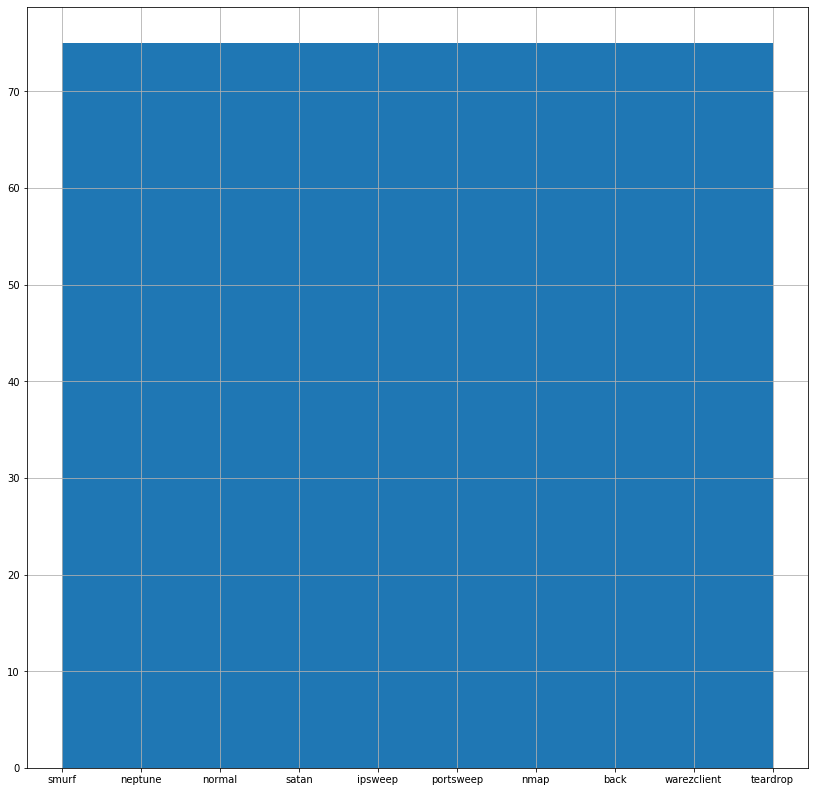

In [40]:
target.value_counts()
target.hist(figsize=(14, 14))

In [42]:
from tensorflow import feature_column
def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [43]:
example_batch = next(iter(dataset))[0]
example_batch

{'duration': <tf.Tensor: id=525, shape=(32,), dtype=float64, numpy=
 array([5.14323921e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])>,
 'protocol_type': <tf.Tensor: id=539, shape=(32,), dtype=int32, numpy=
 array([1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 2], dtype=int32)>,
 'service': <tf.Tensor: id=544, shape=(32,), dtype=int32, numpy=
 array([ 1,  2,  2, 14,  4,  2,  2, 14,  0,  2,  0,  0,  2, 31,  4,  4,  2,
        14,  

In [50]:
protocol = feature_column.numeric_column('protocol_type')
demo(protocol)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [0.]
 [2.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [2.]]


In [54]:
protocol_buckets = feature_column.bucketized_column(protocol, boundaries=[0, 1])
demo(protocol_buckets)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [55]:
protocol = feature_column.categorical_column_with_vocabulary_list(
      'protocol_type', [0, 1, 2])

thal_one_hot = feature_column.indicator_column(protocol)
demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 

In [59]:
attrs = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [58]:
cat_attrs, num_attrs

([1, 2, 3, 41], [0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32])

In [67]:
list(train_df[1].value_counts().keys())

[1, 0, 2]

In [70]:
train_df = train_df.rename(columns={i : new_name for i, new_name in enumerate(features_types_dict)})
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,41
0,0,0,0,0,1032,0,0,0,0,0,...,1,0.01,0.02,0.01,0.0,0.00,0.0,0.00,0.0,smurf
1,0,0,0,0,1032,0,0,0,0,0,...,2,0.01,0.02,0.01,0.0,0.00,0.0,0.00,0.0,smurf
2,0,0,0,0,1032,0,0,0,0,0,...,3,0.02,0.02,0.02,0.0,0.00,0.0,0.00,0.0,smurf
3,0,0,0,0,1032,0,0,0,0,0,...,4,0.03,0.02,0.03,0.0,0.00,0.0,0.00,0.0,smurf
4,0,0,0,0,1032,0,0,0,0,0,...,5,0.03,0.02,0.03,0.0,0.00,0.0,0.00,0.0,smurf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,2,1,0,28,0,0,3,0,0,...,15,0.07,0.71,0.07,0.0,0.03,0.0,0.58,0.0,teardrop
6996,0,2,1,0,28,0,0,3,0,0,...,16,0.07,0.71,0.07,0.0,0.03,0.0,0.58,0.0,teardrop
6997,0,2,1,0,28,0,0,3,0,0,...,17,0.07,0.71,0.07,0.0,0.03,0.0,0.57,0.0,teardrop
6998,0,2,1,0,28,0,0,3,0,0,...,18,0.08,0.71,0.08,0.0,0.03,0.0,0.57,0.0,teardrop


In [73]:
feature_columns = []

# численные столбцы
for header in num_attrs:
    feature_columns.append(feature_column.numeric_column(attrs[header]))

# столбцы индикаторы
for header in cat_attrs[:-1]:
    l = list(train_df[attrs[header]].value_counts().keys())
    thal = feature_column.categorical_column_with_vocabulary_list(
          attrs[header], l)
    one_hot = feature_column.indicator_column(thal)
    feature_columns.append(one_hot)

In [78]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [112]:
def get_compiled_model():
    model = tf.keras.Sequential([
        feature_layer,
        #tf.keras.layers.Dense(25, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [111]:
model = get_compiled_model()
epochs = 10
history = model.fit(dataset, validation_data=val_dataset, use_multiprocessing=True, epochs=epochs)

ValueError: Passing a dictionary input to a Sequential Model which doesn't have FeatureLayer as the first layer is an error.

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [103]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

63/63 [==============================] - 0s 7ms/step - loss: 1.7324 - accuracy: 0.7830
Accuracy on test dataset: 0.783
